\title{BJT Charteristic Anyslies via PySpice}
\author{Steven K Armour}
\maketitle

# Setup
The goal of this work is to show how to accure all the pertinit measurmnts to fully chaertize a BJT Transister and make predictions for use in cirucit desighn. This exsample is an exstations of the basic BJT Tranister Chaterisi meauement esample https://pyspice.fabrice-salvaire.fr/examples/transistor/transistor.html in PySpice by  Fabrice Salvaire. 
For the recored Pyspice is not cirucit simultor in its self inseted it is a python API front in to NGSpice 

## What this work could lead to
Right now cirucit devlopment is domintted by toboloty devlopment and lots of guess and cheak using archaiic systems. With acess to ngspice from within python cirucit devlopment can be done smater by for front end predction of data and not on ad hoc eautons and the possopley in introduce machine learning. 

## Generic python  libarys used

In [1]:
import numpy as np
from scipy.optimize import fsolve, curve_fit
from scipy import interpolate as SciInterPol
import scipy.constants as consts
from collections import OrderedDict

from sympy import *
init_printing()

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Imports sceficly from PySpice

In [2]:
import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()
from PySpice.Probe.Plot import plot
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *

## Loading in Spice Model files
for this exsamplle the On Semiconductor 2N222a BJT spice model is stred in a text file (.lib) in a folder parral to this notebook (for convince). the dicectory given to python and then to the `SpiceLibrary` function found (API: https://pyspice.fabrice-salvaire.fr/api/PySpice/Spice/Library.html) that then purisises the directory for the said .lib (it only looks for '.lib', '.mod', '.lib@xyce', '.mod@xyce'  spice model file types)

In [3]:
libraries_path = 'SpiceLib/'
spice_library = SpiceLibrary(libraries_path)

2018-01-24 23:49:56,145 - PySpice.Spice.Library.Library.__init__ - DEBUG - Parse SpiceLib/2N2901a.lib
2018-01-24 23:49:56,147 - PySpice.Spice.Library.Library.__init__ - DEBUG - Parse SpiceLib/2N2222A.lib


# Things to do
- Clean & doc
- VTC Curve anylsis
- Impulse REsponce test
- Chua's Q point find
- Generices and bind to moduel

propboly going to parse this out into a series of notebooks, cause I maybe got a little excited

#  The input curve Data

## The Test Cirucit

<img src="https://pyspice.fabrice-salvaire.fr/_images/transistor.png>

In [4]:
circuit = Circuit('Transistor')
#circuit permeters
Rb=1@u_kΩ; Rc=1@u_kΩ; VcollMax=3; TempC=25

Vbase = circuit.V('base', '1', circuit.gnd, 1@u_V)
circuit.R('base', 1, 'base', Rb)
Vcollector = circuit.V('collector', '2', circuit.gnd, 0@u_V)
circuit.R('collector', 2, 'collector', Rc)
# circuit.BJT(1, 'collector', 'base', circuit.gnd, 'generic')
# circuit.model('generic', 'npn')
circuit.include(spice_library['2n2222a'])
circuit.BJT(1, 'collector', 'base', circuit.gnd, '2n2222a')

BipolarJunctionTransistor Q1

## Input Curve ($V_{be}$ vs. $I_b$)
$$I_b=f(V_{be})$$

In [5]:
simulator = circuit.simulator(temperature=TempC, nominal_temperature=TempC)
analysisInputCurve = simulator.dc(Vbase=slice(0, VcollMax, .01))
#! Need to figure out how to disable this message strings on the fly

2018-01-24 23:49:56,367 - PySpice.Spice.NgSpice.Shared.NgSpiceShared.new_instance - INFO - New instance for id 0
2018-01-24 23:49:56,480 - PySpice.Spice.NgSpice.Shared.NgSpiceShared.exec_command - DEBUG - Execute command: set nomoremode
2018-01-24 23:49:56,482 - PySpice.Spice.Simulation.NgSpiceSharedCircuitSimulator._run - DEBUG - desk
.title Transistor
.include /home/iridium/string12oil@gmail.com/MyProjects/EEM-Circuits/SpiceLib/2N2222A.lib
Vbase 1 0 1V
Rbase 1 base 1kOhm
Vcollector 2 0 0V
Rcollector 2 collector 1kOhm
Q1 collector base 0 2n2222a 
.options TEMP = 25°C
.options TNOM = 25°C
.ic 
.dc Vbase 0 3 0.01
.end

2018-01-24 23:49:56,482 - PySpice.Spice.NgSpice.Shared.NgSpiceShared.exec_command - DEBUG - Execute command: destroy all
2018-01-24 23:49:56,495 - PySpice.Spice.NgSpice.Shared.NgSpiceShared.run - DEBUG - Simulation is done
2018-01-24 23:49:56,496 - PySpice.Spice.Simulation.NgSpiceSharedCircuitSimulator._run - DEBUG - ['dc1', 'const']


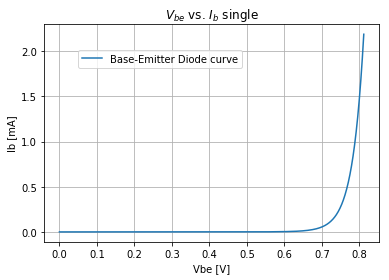

In [6]:
plt.title('$V_{be}$ vs. $I_b$ single')
plt.plot(analysisInputCurve.base, -analysisInputCurve.Vbase*1000) # Fixme: I_Vbase, unit scale
plt.legend(('Base-Emitter Diode curve',), loc=(.1,.8))
plt.grid()
plt.xlabel('Vbe [V]'); plt.ylabel('Ib [mA]');

### Input Curve Set
if the following we take advantge of the Python Pandas libary and PySPice to quicly setup a serires of simultion sweeps and capture there dtata in a essently sudo database

In [7]:
InputData=pd.DataFrame()
for Vce in np.arange(0, 5+1, 1):
    Vcollector.dc_value=Vce@u_V
    analysisInputCurve = simulator.dc(Vbase=slice(0, 3, .01))
    InputData[f'Vbe[V];{Vce}']=analysisInputCurve.base
    InputData[f'Ib[A];{Vce}']=-analysisInputCurve.Vbase


    

2018-01-24 23:49:56,996 - PySpice.Spice.Simulation.NgSpiceSharedCircuitSimulator._run - DEBUG - desk
.title Transistor
.include /home/iridium/string12oil@gmail.com/MyProjects/EEM-Circuits/SpiceLib/2N2222A.lib
Vbase 1 0 1V
Rbase 1 base 1kOhm
Vcollector 2 0 0.0V
Rcollector 2 collector 1kOhm
Q1 collector base 0 2n2222a 
.options TEMP = 25°C
.options TNOM = 25°C
.ic 
.dc Vbase 0 3 0.01
.end

2018-01-24 23:49:56,998 - PySpice.Spice.NgSpice.Shared.NgSpiceShared.exec_command - DEBUG - Execute command: destroy all
2018-01-24 23:49:57,001 - PySpice.Spice.NgSpice.Shared.NgSpiceShared.run - DEBUG - Simulation is done
2018-01-24 23:49:57,002 - PySpice.Spice.Simulation.NgSpiceSharedCircuitSimulator._run - DEBUG - ['dc1', 'const']
2018-01-24 23:49:57,005 - PySpice.Spice.Simulation.NgSpiceSharedCircuitSimulator._run - DEBUG - desk
.title Transistor
.include /home/iridium/string12oil@gmail.com/MyProjects/EEM-Circuits/SpiceLib/2N2222A.lib
Vbase 1 0 1V
Rbase 1 base 1kOhm
Vcollector 2 0 1.0V
Rcollector 2

Graphing the outputs

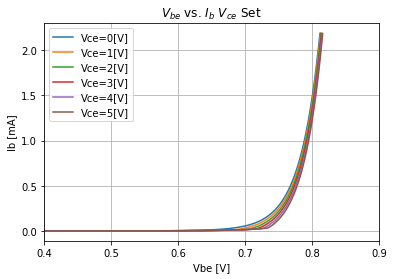

In [8]:
#! need to incapsulte this into a function(meth) 
#! also need to move the legend to the side
plt.title('$V_{be}$ vs. $I_b$ $V_{ce}$ Set')

xs=InputData.columns[0::2]
ys=InputData.columns[1::2]
for x, y in zip(xs, ys):
    plt.plot(InputData[x], InputData[y]*1000, label=f'Vce={y[6:]}[V]')
plt.legend(loc='best')
plt.grid()
plt.xlabel('Vbe [V]'); plt.ylabel('Ib [mA]');
plt.xlim(0.4, 0.9);

Small Signal Parmaters

Input:
$$i_B=I_B(V_{BE, Q}+v_{BE}, V_{CE, Q}+v_{CE})-I_{B, Q}$$

$$i_B \approx \dfrac{\partial I_B}{\partial V_{BE}}\bigg\rvert_Q + v_{BE}+\dfrac{\partial I_B}{\partial V_{CE}}\bigg\rvert_Q v_{CE} +..$$

$$i_B \approx \dfrac{1}{r_{\pi}}v_{BE}+ g_{\pi}v_{CE}$$

Output:

$$i_C=I_C(V_{BE, Q}+v_{BE}, V_{CE, Q}+v_{CE})-I_{C, Q}$$

$$i_C \approx \dfrac{\partial I_C}{\partial V_{BE}}\bigg\rvert_Q + v_{BE}+\dfrac{\partial I_C}{\partial V_{CE}}\bigg\rvert_Q v_{CE} +..$$

$$i_C \approx g_{m} v_{BE}+ \dfrac{1}{r_{0}}v_{CE}$$


Tietze & Schenk 2nd Ed 41-43


### Input Resistance
$$g_{\pi}=\dfrac{\partial I_b}{\partial V_{be}}$$

In [9]:
xs=InputData.columns[0::2]
ys=InputData.columns[1::2]
InputCondutance=pd.DataFrame()
for x, y in zip(xs, ys):
    InputCondutance[x]=InputData[x]
    InputCondutance[f'gpi;{y[6:]}']=np.gradient(InputData[y], InputData[x])
InputCondutance.describe()

,Vbe[V];0,gpi;0,Vbe[V];1,gpi;1,Vbe[V];2,gpi;2,Vbe[V];3,gpi;3,Vbe[V];4,gpi;4,Vbe[V];5,gpi;5
count,3.010000e+02,3.010000e+02,3.010000e+02,3.010000e+02,3.010000e+02,3.010000e+02,3.010000e+02,3.010000e+02,3.010000e+02,3.010000e+02,3.010000e+02,3.010000e+02
mean,6.791673e-01,2.745422e-02,6.808358e-01,2.815954e-02,6.822101e-01,2.887341e-02,6.834671e-01,2.959622e-02,6.846464e-01,3.032862e-02,6.857641e-01,3.106991e-02
std,2.103343e-01,2.414132e-02,2.108504e-01,2.453145e-02,2.113884e-01,2.493254e-02,2.119131e-01,2.534460e-02,2.124238e-01,2.576734e-02,2.129210e-01,2.620199e-02
min,4.652014e-26,3.041871e-10,1.115396e-08,2.052600e-10,1.216694e-08,2.052191e-10,1.316825e-08,2.052156e-10,1.416857e-08,2.052156e-10,1.516868e-08,2.052156e-10
25%,6.982164e-01,1.631662e-03,7.064140e-01,2.035259e-03,7.136072e-01,2.446076e-03,7.199527e-01,2.745902e-03,7.248942e-01,1.771334e-03,7.249347e-01,5.817966e-04
50%,7.787331e-01,2.414242e-02,7.803279e-01,2.501656e-02,7.818910e-01,2.590763e-02,7.834239e-01,2.681623e-02,7.849279e-01,2.774293e-02,7.864040e-01,2.868825e-02
75%,7.995846e-01,4.858901e-02,8.006212e-01,4.965083e-02,8.016466e-01,5.072943e-02,8.026612e-01,5.182517e-02,8.036650e-01,5.293842e-02,8.046584e-01,5.406950e-02
max,8.118732e-01,7.293963e-02,8.126843e-01,7.414117e-02,8.134894e-01,7.535914e-02,8.142884e-01,7.659380e-02,8.150814e-01,7.784544e-02,8.158686e-01,7.911430e-02


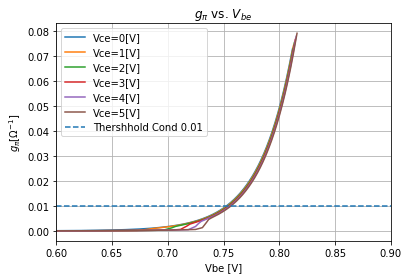

In [10]:
plt.title('$g_{\pi}$ vs. $V_{be}$')

xs=InputCondutance.columns[0::2]
ys=InputCondutance.columns[1::2]
for x, y in zip(xs, ys):
    plt.plot(InputCondutance[x], InputCondutance[y], label=f'Vce={y[4:]}[V]')
plt.axhline(y=0.01, linestyle='--', label='Thershhold Cond 0.01')
plt.legend(loc='best')
plt.grid()
plt.xlabel('Vbe [V]'); plt.ylabel(r'$g_{\pi}[\Omega^{-1}]$')
plt.xlim(0.6, 0.9);


#### fiting fiting with the data from the def of the $r_{\pi}$
Horenstein page 329 Eq 8.15

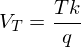

In [11]:
VTherm, k, T, q=symbols('V_T, k, T, q')
VThermDef=k*T/q
VThermEq=Eq(VTherm, VThermDef)
VThermEq

In [12]:
supsVT={T:consts.convert_temperature(TempC, 'C', 'K'), 
       k:consts.Boltzmann, q:consts.elementary_charge}
VThermEq.subs(supsVT)

In [13]:
rpi, fit, Ib=symbols('r_pi, eta, I_b')

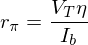

In [14]:
rpiDef=fit*VTherm/Ib; rpiDef
rpiEq=Eq(rpi, rpiDef)
rpiEq

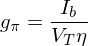

In [15]:
gpi=symbols('g_pi')
gpiDef=1/rpiDef
gpiEq=Eq(gpi, gpiDef)
gpiEq

In [16]:
rpiN=lambdify((Ib, fit), rpiDef.subs({VTherm: VThermDef.subs(supsVT)}),
              dummify=False)

In [17]:
xs=InputData.columns[1::2] #Ib currents
ys=InputCondutance.columns[1::2] #g_{\pi}
fitNs=[]; fitNsError=[]
for x, y in zip(xs, ys):
    fitN, pcov=curve_fit(rpiN, InputData[x], 1/InputCondutance[y])
    fitNs.append(*fitN); fitNsError.append(*pcov)
fitNs=np.array(fitNs); fitNsError=np.array(fitNsError)
fitNs, fitNsError

(array([ -5.95240911e-18,  -1.18368181e-02,   2.35496974e-02,
         -6.60911863e-02,  -1.44024079e-01,  -1.07981531e-01]),
 array([[  2.82122197e-37],
        [  4.82126183e-04],
        [  4.41935323e-05],
        [  1.24380429e-04],
        [  6.07288427e-04],
        [  9.00137528e-04]]))

In [18]:
fitN=fitNs.mean(); fitNError=fitNsError.mean()
fitN, fitNError

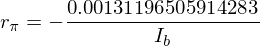

In [19]:
sups_rpi={**{fit:fitN}, **{VTherm: VThermDef.subs(supsVT)}}
rpiEq.subs(sups_rpi)

In [20]:
gpiEq.subs(sups_rpi)

### Using the Input Resistince to determine the threshhold voltage

In [21]:
#https://www.science-emergence.com/Articles/Find-nearest-value-and-the-index-in-array-with-python-and-numpy/
D1LocFinder=lambda Array, Target: np.abs(Array-Target).idxmin()

In [22]:
TurnOnCondition=0.01
xs=InputCondutance.columns[0::2]
ys=InputCondutance.columns[1::2]

ThreshholdV_locs={x:D1LocFinder(InputCondutance[y], TurnOnCondition) for x, y in zip(xs, ys)}
ThreshholdV_locs

{'Vbe[V];0': 105,
 'Vbe[V];1': 103,
 'Vbe[V];2': 101,
 'Vbe[V];3': 99,
 'Vbe[V];4': 96,
 'Vbe[V];5': 94}

In [23]:

ThreshholdV_vals={i:InputCondutance[i][j] for i, j in ThreshholdV_locs.items()}
ThreshholdV_vals

{'Vbe[V];0': 0.75219550241186717,
 'Vbe[V];1': 0.75323315593474949,
 'Vbe[V];2': 0.75427126747877349,
 'Vbe[V];3': 0.7553101908618296,
 'Vbe[V];4': 0.75544317971273678,
 'Vbe[V];5': 0.75649001346422717}

In [24]:
Threshhold_VoltageVals=np.array([*ThreshholdV_vals.values()])
ThershholdVoltageMean=Threshhold_VoltageVals.mean()
ThershholdVoltageStdDev=Threshhold_VoltageVals.std()
#ThershholdVoltageMean, ThershholdVoltageStdDev
ThershholdVoltageMean=np.around([ThershholdVoltageMean], decimals=3)
ThershholdVoltageStdDev=np.around([ThershholdVoltageStdDev], decimals=3)
ThershholdVoltageMean, ThershholdVoltageStdDev


(array([ 0.754]), array([ 0.001]))

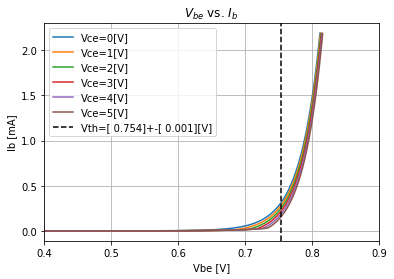

In [25]:
plt.title('$V_{be}$ vs. $I_b$')

xs=InputData.columns[0::2]
ys=InputData.columns[1::2]
for x, y in zip(xs, ys):
    plt.plot(InputData[x], InputData[y]*1000, label=f'Vce={y[6:]}[V]')
plt.axvline(x=ThershholdVoltageMean, linestyle='--', color='k', 
            label=f'Vth={ThershholdVoltageMean}+-{ThershholdVoltageStdDev}[V]')
plt.legend(loc='best')
plt.grid()
plt.xlabel('Vbe [V]'); plt.ylabel('Ib [mA]');
plt.xlim(0.4, 0.9);

## Input load line anylsis
This will be used for proper Q point determition as shown by the master Leon Chua in 4.2 of got to look up the book from the pages I scanned

In [26]:
def findIntersection(f1, f2, x0):
    return fsolve(lambda x:f1(x)-f2(x), x0)

In [27]:
def LoadLine(Vmax, R):
    b=Vmax/R; m=-1/R
    f=lambda x:m*x+b
    return m, b, f
m, b, L1Line=LoadLine(1.5, Rb)
m, b

In [28]:
#create 1D interpolation functions to the input curve data
xs=InputData.columns[0::2]
ys=InputData.columns[1::2]

InputFits=OrderedDict()
for x, y in zip(xs, ys):
    InputFits[y]=SciInterPol.interp1d(InputData[x], InputData[y], 
                                      bounds_error=False, fill_value='extrapolate')

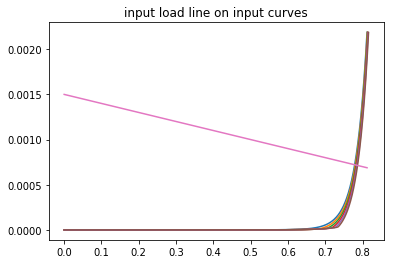

In [29]:
plt.title('input load line on input curves')
for x, y in zip(xs, InputFits.keys()):
    plt.plot(InputData[x], InputFits[y](InputData[x]))
xN=np.linspace(0, InputData[xs[0]].max(), InputData[xs[0]].count())
plt.plot(xN, L1Line(xN))

In [30]:
K=list(InputFits.keys()); K

['Ib[A];0', 'Ib[A];1', 'Ib[A];2', 'Ib[A];3', 'Ib[A];4', 'Ib[A];5']

In [31]:
LoadLineInterSectionsX=[]
LoadLineInterSectionsY=[]
x=np.linspace(0.0, InputData[xs[0]].max(), InputData[xs[0]].count())
for i in K:
    X=findIntersection(InputFits[i] ,L1Line , 0.6)
    print(X)
    LoadLineInterSectionsX.append(X[0])
    LoadLineInterSectionsY.append(InputFits[i](LoadLineInterSectionsX[-1]))

LoadLineInterSectionsX=np.array(LoadLineInterSectionsX)
LoadLineInterSectionsY=np.array(LoadLineInterSectionsY)
LoadLineInterSectionsX, LoadLineInterSectionsY


[ 0.7787331]
[ 0.78032789]
[ 0.78189105]
[ 0.78342395]
[ 0.78492787]
[ 0.78640397]


(array([ 0.7787331 ,  0.78032789,  0.78189105,  0.78342395,  0.78492787,
         0.78640397]),
 array([ 0.00072127,  0.00071967,  0.00071811,  0.00071658,  0.00071507,
         0.0007136 ]))

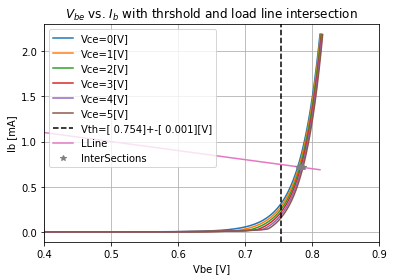

In [32]:
plt.title('$V_{be}$ vs. $I_b$ with thrshold and load line intersection')

xs=InputData.columns[0::2]
ys=InputData.columns[1::2]

for x, y in zip(xs, ys):
    plt.plot(InputData[x], InputData[y]*1000, label=f'Vce={y[6:]}[V]')

#add thereshold line
plt.axvline(x=ThershholdVoltageMean, linestyle='--', color='k', 
            label=f'Vth={ThershholdVoltageMean}+-{ThershholdVoltageStdDev}[V]')

xN=np.linspace(0.0, InputData[xs[0]].max(), InputData[xs[0]].count())

plt.plot(xN, L1Line(xN)*1000, label='LLine')
plt.plot(LoadLineInterSectionsX, LoadLineInterSectionsY*1000, '*', 
         label='InterSections')
plt.legend(loc='best')
plt.grid()
plt.xlabel('Vbe [V]'); plt.ylabel('Ib [mA]');
plt.xlim(0.4, 0.9);

In [33]:
LoadLineInterSectionsY

array([ 0.00072127,  0.00071967,  0.00071811,  0.00071658,  0.00071507,
        0.0007136 ])

In [34]:
Vce_s=np.array([float(i[6:]) for i in K]); Vce_s

array([ 0.,  1.,  2.,  3.,  4.,  5.])

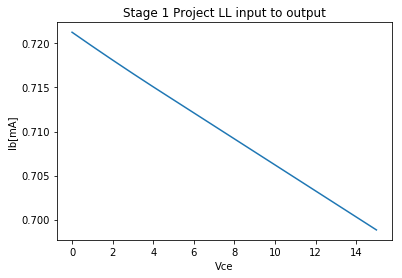

In [35]:
L1LineOutput=SciInterPol.interp1d(Vce_s, LoadLineInterSectionsY,
                                     bounds_error=False, fill_value='extrapolate')
plt.plot(np.linspace(0, 15), L1LineOutput(np.linspace(0, 15))*1000)
plt.xlabel('Vce'); plt.ylabel('Ib[mA]')
plt.title('Stage 1 Project LL input to output');

# VTC

In [36]:
circuit = Circuit('Transistor')
Rb=1@u_kΩ; Rc=1@u_kΩ; VcollMax=3; TempC=25

Vbase = circuit.V('base', '1', circuit.gnd, 1@u_V)
circuit.R('base', 1, 'base', Rb)
Vcollector = circuit.V('collector', '2', circuit.gnd, 0@u_V)
circuit.R('collector', 2, 'collector', Rc)
# circuit.BJT(1, 'collector', 'base', circuit.gnd, 'generic')
# circuit.model('generic', 'npn')
circuit.include(spice_library['2n2222a'])
circuit.BJT(1, 'collector', 'base', circuit.gnd, '2n2222a')

BipolarJunctionTransistor Q1

In [37]:
simulator = circuit.simulator(temperature=TempC, nominal_temperature=TempC)
analysisInputCurve = simulator.dc(Vbase=slice(0, VcollMax, .01))

2018-01-24 23:50:02,473 - PySpice.Spice.Simulation.NgSpiceSharedCircuitSimulator._run - DEBUG - desk
.title Transistor
.include /home/iridium/string12oil@gmail.com/MyProjects/EEM-Circuits/SpiceLib/2N2222A.lib
Vbase 1 0 1V
Rbase 1 base 1kOhm
Vcollector 2 0 0V
Rcollector 2 collector 1kOhm
Q1 collector base 0 2n2222a 
.options TEMP = 25°C
.options TNOM = 25°C
.ic 
.dc Vbase 0 3 0.01
.end

2018-01-24 23:50:02,474 - PySpice.Spice.NgSpice.Shared.NgSpiceShared.exec_command - DEBUG - Execute command: destroy all
2018-01-24 23:50:02,479 - PySpice.Spice.NgSpice.Shared.NgSpiceShared.run - DEBUG - Simulation is done
2018-01-24 23:50:02,480 - PySpice.Spice.Simulation.NgSpiceSharedCircuitSimulator._run - DEBUG - ['dc1', 'const']


In [38]:
#collect vtc curve
VTCData=pd.DataFrame()
#need to douple check to make sure I am calling the right vi vo values
VTCData['Vin']=analysisInputCurve.base
VTCData['Vout']= -analysisInputCurve.collector

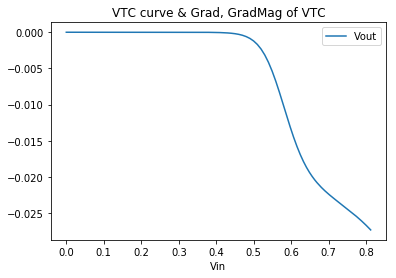

In [39]:
VTCData.plot(x='Vin', title='VTC curve & Grad, GradMag of VTC')

In [40]:
VTCData['Grad']=np.gradient(VTCData['Vout'], VTCData['Vin'])
VTCData['GradMag']=np.abs(VTCData['Grad'])
VTCData['GGrad']=np.gradient(VTCData['Grad'], VTCData['Vin'])
VTCData.head(5)

,Vin,Vout,Grad,GradMag,GGrad
0,4.652014e-26,1.707819e-26,-1.000157e-07,1.000157e-07,-0.000001
1,9.999997e-03,-1.000156e-09,-1.103598e-07,1.103598e-07,-0.000001
2,1.999999e-02,-2.207196e-09,-1.241133e-07,1.241133e-07,-0.000001
3,2.999999e-02,-3.482421e-09,-1.340621e-07,1.340621e-07,-0.000001
4,3.999998e-02,-4.888437e-09,-1.478507e-07,1.478507e-07,-0.000001


In [41]:
VILLoc=np.abs(VTCData['GGrad']--1.0).idxmax()
VIHLoc=np.abs(VTCData['GGrad']--1.0).idxmin()
VIHLoc=np.abs(VTCData['GGrad']--1.0).idxmin()
VIMLoc=np.abs(VTCData['Grad']-0).idxmax()
VILLoc, VIHLoc, VIMLoc
VILV=VTCData['Vin'][VILLoc]; VOLV=VTCData['Vout'][VILLoc]
VIHV=VTCData['Vin'][VIHLoc]; VOHV=VTCData['Vout'][VIHLoc]
VIMV=VTCData['Vin'][VIMLoc]; VOMV=VTCData['Vout'][VIMLoc]

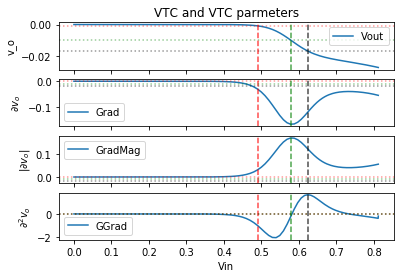

In [42]:
fig, [vtc, vtcGrad, vtcGradM,  vtcGGrad]=plt.subplots(nrows=4, ncols=1, sharex=True)
vtc.set_title('VTC and VTC parmeters')

VTCData.plot(x='Vin', y='Vout', ax=vtc)
vtc.set_ylabel('v_o')

VTCData.plot(x='Vin', y='Grad', ax=vtcGrad)
vtcGrad.set_ylabel(r'$\partial v_o$')

VTCData.plot(x='Vin', y='GradMag', ax=vtcGradM)
vtcGradM.set_ylabel(r'$|\partial v_o|$')

VTCData.plot(x='Vin', y='GGrad', ax=vtcGGrad);
vtcGGrad.set_ylabel(r'$\partial^2 v_o$')


for i in [vtc, vtcGrad, vtcGGrad, vtcGradM]:
    i.axvline(x=VILV, linestyle='--', alpha=0.7, color='k')
    i.axhline(y=VOLV, linestyle=':', alpha=0.4, color='k')
    
    i.axvline(x=VIHV, linestyle='--', alpha=0.7, color='r')
    i.axhline(y=VOHV, linestyle=':', alpha=0.4, color='r')

    i.axvline(x=VIMV, linestyle='--', alpha=0.7, color='g')
    i.axhline(y=VOMV, linestyle=':', alpha=0.4, color='g')






like to do fitting around the GradMag and also find the FWHM to then find the standard devation with would be the loss of Av per devation from the Av Max

from sec 1.4 of DeMassa & Ciccone 

In [43]:
VTCMeassures={'LogicSwing':VOHV-VOLV,
            'TranssitionWidth':VIHV-VILV,
             'NoiseMarHigh':VOHV-VIHV,
             'NoiseMarLow':VILV-VOLV,
             'NoiseSenHigh': VOHV-VIMV,
             'NoiseSenLow': VIMV-VOLV          
            }
VTCMeassures['NoiseImmuntyHigh']=VTCMeassures['NoiseSenHigh']/VTCMeassures['LogicSwing']
VTCMeassures['NoiseImmuntyLow']=VTCMeassures['NoiseSenHigh']/VTCMeassures['LogicSwing']
VTCMeassures

{'LogicSwing': 0.016062403524019477,
 'NoiseImmuntyHigh': -36.047191893526573,
 'NoiseImmuntyLow': -36.047191893526573,
 'NoiseMarHigh': -0.49062954368294137,
 'NoiseMarLow': 0.64098632035666736,
 'NoiseSenHigh': -0.57900454210158758,
 'NoiseSenLow': 0.59506694562560714,
 'TranssitionWidth': -0.13429437314970649}

In [44]:
VTCFit=SciInterPol.interp1d(VTCData['Vin'], VTCData['Vout'],
                            bounds_error=False, fill_value='extrapolate')


### Distrortion Anyleis
This is my attempt at this; be nice

In [45]:
Vbias=np.where(VTCData['GradMag']==VTCData['GradMag'].max())
Vbias=np.array(VTCData['Vin'][Vbias[0]])

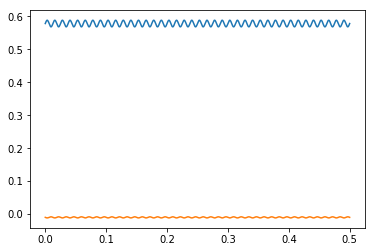

In [46]:
tN=np.linspace(0, .5, 1000)
SinIn=Vbias+.01*np.sin(80e3*2*np.pi*tN)
SinOut=VTCFit(SinIn)
plt.plot(tN, SinIn)
plt.plot(tN, SinOut)

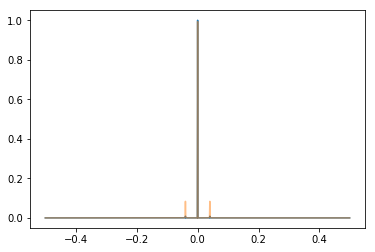

In [47]:
SinInF=np.fft.fftshift(np.fft.fft(SinIn))
SinInFNorm=SinInF/np.linalg.norm(SinInF)

SinOutF=np.fft.fftshift(np.fft.fft(SinOut))
SinOutFNorm=SinOutF/np.linalg.norm(SinOutF)


Fs=np.fft.fftshift(np.fft.fftfreq(len(tN)))
plt.plot(Fs, np.abs(SinInFNorm), label='InNorm')
plt.plot(Fs, np.abs(SinOutFNorm), alpha=.5, label='OutNorm')


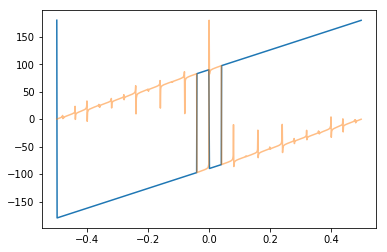

In [48]:
plt.plot(Fs, np.rad2deg(np.angle(SinInFNorm)), label='InNorm')
plt.plot(Fs, np.rad2deg(np.angle(SinOutFNorm)), alpha=0.5, label='OutNorm')

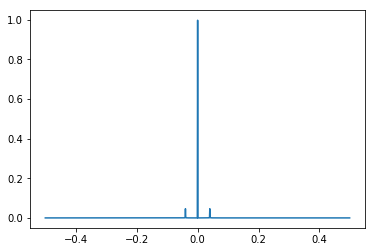

In [49]:
DisF=np.abs(SinInFNorm-SinOutFNorm)
DisF=DisF/np.linalg.norm(DisF)
plt.plot(Fs, DisF)

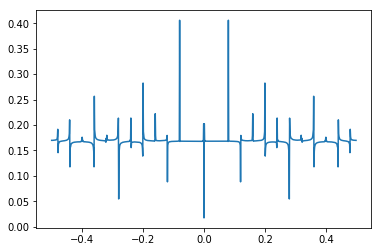

In [50]:
H=SinOutF/SinInF
plt.plot(Fs, np.abs(H))

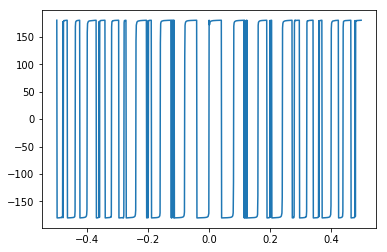

In [51]:
plt.plot(Fs, np.rad2deg(np.angle(H)))

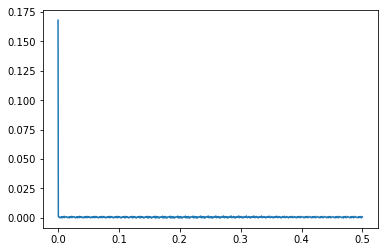

In [52]:
h=np.abs((np.fft.ifft(H)))
plt.plot(tN, h)

In [53]:
DisT=np.abs((np.fft.ifft(H)))


# Output Curves

In [54]:
OutputData=pd.DataFrame()
for Vce in np.arange(0, 5+1, 1):
    Vcollector.dc_value=Vce@u_V
    analysisInputCurve = simulator.dc(Vbase=slice(0, 3, .01))
    InputData[f'Vbe[V];{Vce}']=analysisInputCurve.base
    InputData[f'Ib[A];{Vce}']=-analysisInputCurve.Vbase

2018-01-24 23:50:05,424 - PySpice.Spice.Simulation.NgSpiceSharedCircuitSimulator._run - DEBUG - desk
.title Transistor
.include /home/iridium/string12oil@gmail.com/MyProjects/EEM-Circuits/SpiceLib/2N2222A.lib
Vbase 1 0 1V
Rbase 1 base 1kOhm
Vcollector 2 0 0.0V
Rcollector 2 collector 1kOhm
Q1 collector base 0 2n2222a 
.options TEMP = 25°C
.options TNOM = 25°C
.ic 
.dc Vbase 0 3 0.01
.end

2018-01-24 23:50:05,425 - PySpice.Spice.NgSpice.Shared.NgSpiceShared.exec_command - DEBUG - Execute command: destroy all
2018-01-24 23:50:05,428 - PySpice.Spice.NgSpice.Shared.NgSpiceShared.run - DEBUG - Simulation is done
2018-01-24 23:50:05,429 - PySpice.Spice.Simulation.NgSpiceSharedCircuitSimulator._run - DEBUG - ['dc1', 'const']
2018-01-24 23:50:05,432 - PySpice.Spice.Simulation.NgSpiceSharedCircuitSimulator._run - DEBUG - desk
.title Transistor
.include /home/iridium/string12oil@gmail.com/MyProjects/EEM-Circuits/SpiceLib/2N2222A.lib
Vbase 1 0 1V
Rbase 1 base 1kOhm
Vcollector 2 0 1.0V
Rcollector 2

In [55]:
Rb=1@u_kΩ; Rc=1@u_kΩ; VcollMax=3; TempC=25

circuit = Circuit('Transistor')
Ibase = circuit.I('base', circuit.gnd, 'base', 10@u_uA) # take care to the orientation
Vcollector = circuit.V('collector', 'collector', circuit.gnd, 5)
# circuit.BJT(1, 'collector', 'base', circuit.gnd, 'generic')
# circuit.model('generic', 'npn')
circuit.include(spice_library['2n2222a'])
circuit.BJT(1, 'collector', 'base', circuit.gnd, '2n2222a')


BipolarJunctionTransistor Q1

In [56]:
simulator = circuit.simulator(temperature=TempC, nominal_temperature=TempC)
analysis = simulator.dc(Vcollector=slice(0, 5, .01))

2018-01-24 23:50:05,656 - PySpice.Spice.Simulation.NgSpiceSharedCircuitSimulator._run - DEBUG - desk
.title Transistor
.include /home/iridium/string12oil@gmail.com/MyProjects/EEM-Circuits/SpiceLib/2N2222A.lib
Ibase 0 base 10uA
Vcollector collector 0 5
Q1 collector base 0 2n2222a 
.options TEMP = 25°C
.options TNOM = 25°C
.ic 
.dc Vcollector 0 5 0.01
.end

2018-01-24 23:50:05,657 - PySpice.Spice.NgSpice.Shared.NgSpiceShared.exec_command - DEBUG - Execute command: destroy all
2018-01-24 23:50:05,663 - PySpice.Spice.NgSpice.Shared.NgSpiceShared.run - DEBUG - Simulation is done
2018-01-24 23:50:05,664 - PySpice.Spice.Simulation.NgSpiceSharedCircuitSimulator._run - DEBUG - ['dc1', 'const']


2018-01-24 23:50:05,779 - PySpice.Spice.Simulation.NgSpiceSharedCircuitSimulator._run - DEBUG - desk
.title Transistor
.include /home/iridium/string12oil@gmail.com/MyProjects/EEM-Circuits/SpiceLib/2N2222A.lib
Ibase 0 base 0.0uA
Vcollector collector 0 5
Q1 collector base 0 2n2222a 
.options TEMP = 25°C
.options TNOM = 25°C
.ic 
.dc Vcollector 0 5 0.01
.end

2018-01-24 23:50:05,780 - PySpice.Spice.NgSpice.Shared.NgSpiceShared.exec_command - DEBUG - Execute command: destroy all
2018-01-24 23:50:05,785 - PySpice.Spice.NgSpice.Shared.NgSpiceShared.run - DEBUG - Simulation is done
2018-01-24 23:50:05,786 - PySpice.Spice.Simulation.NgSpiceSharedCircuitSimulator._run - DEBUG - ['dc1', 'const']
2018-01-24 23:50:05,830 - PySpice.Spice.Simulation.NgSpiceSharedCircuitSimulator._run - DEBUG - desk
.title Transistor
.include /home/iridium/string12oil@gmail.com/MyProjects/EEM-Circuits/SpiceLib/2N2222A.lib
Ibase 0 base 10.0uA
Vcollector collector 0 5
Q1 collector base 0 2n2222a 
.options TEMP = 25°C
.

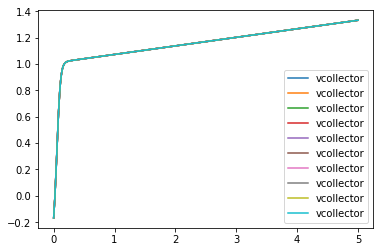

In [57]:
simulator = circuit.simulator(temperature=25, nominal_temperature=25)

for base_current in np.arange(0, 100, 10):
    base_current = base_current@u_uA
    Ibase.dc_value = base_current
    analysisOut = simulator.dc(Vcollector=slice(0, 5, .01))
    plt.plot(analysis.collector, -analysis.Vcollector*1000)

plt.legend()

In [58]:
OutputData=pd.DataFrame()
for Ib in np.arange(0, 100, 10):
    Ibase.dc_value = Ib@u_uA
    analysisOutputCurve = simulator.dc(Vcollector=slice(0, 5, .01))
    OutputData[f'Vce[V];{Ib}u']=analysisOutputCurve.collector
    OutputData[f'Ic[A];{Ib}u']=-analysisOutputCurve.Vcollector

2018-01-24 23:50:06,160 - PySpice.Spice.Simulation.NgSpiceSharedCircuitSimulator._run - DEBUG - desk
.title Transistor
.include /home/iridium/string12oil@gmail.com/MyProjects/EEM-Circuits/SpiceLib/2N2222A.lib
Ibase 0 base 0.0uA
Vcollector collector 0 5
Q1 collector base 0 2n2222a 
.options TEMP = 25°C
.options TNOM = 25°C
.ic 
.dc Vcollector 0 5 0.01
.end

2018-01-24 23:50:06,162 - PySpice.Spice.NgSpice.Shared.NgSpiceShared.exec_command - DEBUG - Execute command: destroy all
2018-01-24 23:50:06,166 - PySpice.Spice.NgSpice.Shared.NgSpiceShared.run - DEBUG - Simulation is done
2018-01-24 23:50:06,167 - PySpice.Spice.Simulation.NgSpiceSharedCircuitSimulator._run - DEBUG - ['dc1', 'const']
2018-01-24 23:50:06,170 - PySpice.Spice.Simulation.NgSpiceSharedCircuitSimulator._run - DEBUG - desk
.title Transistor
.include /home/iridium/string12oil@gmail.com/MyProjects/EEM-Circuits/SpiceLib/2N2222A.lib
Ibase 0 base 10.0uA
Vcollector collector 0 5
Q1 collector base 0 2n2222a 
.options TEMP = 25°C
.

In [59]:
OutputData.head()

,Vce[V];0u,Ic[A];0u,Vce[V];10u,Ic[A];10u,Vce[V];20u,Ic[A];20u,Vce[V];30u,Ic[A];30u,Vce[V];40u,Ic[A];40u,Vce[V];50u,Ic[A];50u,Vce[V];60u,Ic[A];60u,Vce[V];70u,Ic[A];70u,Vce[V];80u,Ic[A];80u,Vce[V];90u,Ic[A];90u
0,0.00,-4.961523e-28,0.00,-0.000168,0.00,-0.000370,0.00,-0.000577,0.00,-0.000786,0.00,-0.000993,0.00,-0.001198,0.00,-0.001400,0.00,-0.001600,0.00,-0.001796
1,0.01,6.861560e-13,0.01,-0.000095,0.01,-0.000218,0.01,-0.000348,0.01,-0.000480,0.01,-0.000611,0.01,-0.000741,0.01,-0.000871,0.01,-0.000998,0.01,-0.001124
2,0.02,1.351766e-12,0.02,-0.000009,0.02,-0.000035,0.02,-0.000067,0.02,-0.000104,0.02,-0.000142,0.02,-0.000182,0.02,-0.000222,0.02,-0.000264,0.02,-0.000305
3,0.03,1.993600e-12,0.03,0.000089,0.03,0.000181,0.03,0.000267,0.03,0.000346,0.03,0.000420,0.03,0.000488,0.03,0.000551,0.03,0.000611,0.03,0.000666
4,0.04,2.609107e-12,0.04,0.000196,0.04,0.000429,0.04,0.000655,0.04,0.000870,0.04,0.001073,0.04,0.001265,0.04,0.001448,0.04,0.001621,0.04,0.001787


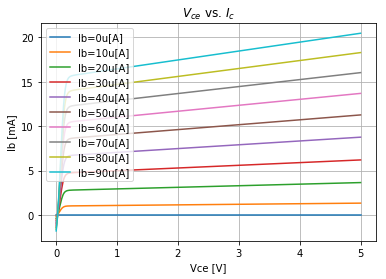

In [60]:
plt.title('$V_{ce}$ vs. $I_c$')

xs=OutputData.columns[0::2]
ys=OutputData.columns[1::2]
for x, y in zip(xs, ys):
    plt.plot(OutputData[x], OutputData[y]*1000, label=f'Ib={y[6:]}[A]')
plt.legend(loc='best')
plt.grid()
plt.xlabel('Vce [V]'); plt.ylabel('Ib [mA]');


## Find the large signal $\beta$
I am more then likly going to redo this for per the exsample

In [61]:
BetaLData=pd.DataFrame()
xs=OutputData.columns[0::2]
ys=OutputData.columns[1::2]
for x, y in zip(xs, ys):
    BetaLData[x]=OutputData[x]
    BetaLData[f'B{y}']=OutputData[y]/(float(y[6:-1])*1e-6)
BetaLData.describe()


/home/iridium/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4392: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


,Vce[V];0u,BIc[A];0u,Vce[V];10u,BIc[A];10u,Vce[V];20u,BIc[A];20u,Vce[V];30u,BIc[A];30u,Vce[V];40u,BIc[A];40u,Vce[V];50u,BIc[A];50u,Vce[V];60u,BIc[A];60u,Vce[V];70u,BIc[A];70u,Vce[V];80u,BIc[A];80u,Vce[V];90u,BIc[A];90u
count,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000
mean,2.500000,NaN,2.500000,115.289449,2.500000,157.688392,2.500000,178.499382,2.500000,189.174665,2.500000,194.553463,2.500000,196.964581,2.500000,197.629426,2.500000,197.231858,2.500000,196.174807
std,1.447705,NaN,1.447705,16.393461,1.447705,22.901602,1.447705,26.210204,1.447705,27.974974,1.447705,28.919825,1.447705,29.398844,1.447705,29.599704,1.447705,29.628387,1.447705,29.547855
min,0.000000,-inf,0.000000,-16.761743,0.000000,-18.493571,0.000000,-19.246853,0.000000,-19.639589,0.000000,-19.851713,0.000000,-19.958762,0.000000,-19.999230,0.000000,-19.994969,0.000000,-19.959498
25%,1.250000,NaN,1.250000,108.834152,1.250000,148.970939,1.250000,168.694914,1.250000,178.826525,1.250000,183.943201,1.250000,186.248824,1.250000,186.899608,1.250000,186.543053,1.250000,185.560750
50%,2.500000,NaN,2.500000,116.937769,2.500000,160.092070,2.500000,181.307117,2.500000,192.209888,2.500000,197.720223,2.500000,200.207277,2.500000,200.914160,2.500000,200.537135,2.500000,199.486588
75%,3.750000,NaN,3.750000,125.041387,3.750000,171.213202,3.750000,193.919320,3.750000,205.593252,3.750000,211.497245,3.750000,214.165730,3.750000,214.928712,3.750000,214.531218,3.750000,213.412427
max,5.000000,inf,5.000000,133.145008,5.000000,182.334336,5.000000,206.531524,5.000000,218.976617,5.000000,225.274267,5.000000,228.124183,5.000000,228.943265,5.000000,228.525301,5.000000,227.338265


In [62]:
ys=BetaLData.columns[1::2]
BetaLMean=np.nan_to_num(np.array(BetaLData[list(ys)].mean())).mean()
BetaLStd=np.nan_to_num(np.array(BetaLData[list(ys)].std())).mean()
BetaLMean, BetaLStd

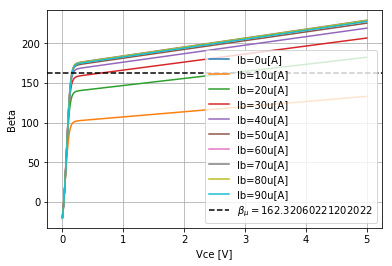

In [63]:
xs=BetaLData.columns[0::2]
ys=BetaLData.columns[1::2]
for x, y in zip(xs, ys):
    plt.plot(BetaLData[x], BetaLData[y], label=f'Ib={x[7:]}[A]')
plt.axhline(y=BetaLMean, linestyle='--', color='k', 
            label=r'$\beta_\mu=$'+f'{BetaLMean}')

plt.legend(loc='best')
plt.grid()
plt.xlabel('Vce [V]'); plt.ylabel('Beta');

## Early resistince
output resistince
    $$r_{ce}=\dfrac{\partial I_c}{\partial V_{ce}}^{-1}$$

In [64]:
rceData=pd.DataFrame()
xs=OutputData.columns[0::2]
ys=OutputData.columns[1::2]
for x, y in zip(xs, ys):
    rceData[x]=OutputData[x]
    rceData[f'gce{y}']=1/np.gradient(OutputData[y], OutputData[x])
rceData.describe()

,Vce[V];0u,gceIc[A];0u,Vce[V];10u,gceIc[A];10u,Vce[V];20u,gceIc[A];20u,Vce[V];30u,gceIc[A];30u,Vce[V];40u,gceIc[A];40u,Vce[V];50u,gceIc[A];50u,Vce[V];60u,gceIc[A];60u,Vce[V];70u,gceIc[A];70u,Vce[V];80u,gceIc[A];80u,Vce[V];90u,gceIc[A];90u
count,501.000000,5.010000e+02,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000
mean,2.500000,4.500095e+11,2.500000,14671.731567,2.500000,5337.331466,2.500000,3135.050615,2.500000,2214.602327,2.500000,1720.334463,2.500000,1414.481547,2.500000,1207.190463,2.500000,1057.547223,2.500000,944.412765
std,1.447705,1.199249e+11,1.447705,3110.015725,1.447705,1151.842827,1.447705,682.710971,1.447705,485.166878,1.447705,378.609624,1.447705,312.469997,1.447705,267.543044,1.447705,235.053404,1.447705,210.455284
min,0.000000,1.457395e+10,0.000000,87.763945,0.000000,34.625418,0.000000,21.156423,0.000000,15.254734,0.000000,12.064658,0.000000,10.079038,0.000000,8.726422,0.000000,7.745595,0.000000,7.001097
25%,1.250000,4.691250e+11,1.250000,15425.197979,1.250000,5619.929401,1.250000,3303.677695,1.250000,2334.987954,1.250000,1814.615319,1.250000,1492.524317,1.250000,1274.185533,1.250000,1116.543206,1.250000,997.346577
50%,2.500000,4.895217e+11,2.500000,15425.205058,2.500000,5619.930818,2.500000,3303.678477,2.500000,2334.988363,2.500000,1814.615644,2.500000,1492.524506,2.500000,1274.185718,2.500000,1116.543340,2.500000,997.346678
75%,3.750000,5.004000e+11,3.750000,15425.210484,3.750000,5619.931622,3.750000,3303.678793,3.750000,2334.988509,3.750000,1814.615729,3.750000,1492.524564,3.750000,1274.185762,3.750000,1116.543370,3.750000,997.346701
max,5.000000,5.629500e+11,5.000000,15425.216618,5.000000,5619.932556,5.000000,3303.679159,5.000000,2334.988713,5.000000,1814.615835,5.000000,1492.524637,5.000000,1274.185813,5.000000,1116.543400,5.000000,997.346726


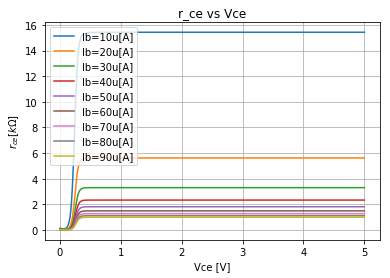

In [65]:
xs=rceData.columns[0::2]
ys=rceData.columns[1::2]
plt.title('r_ce vs Vce')
for x, y in zip(xs, ys):
    if x==xs[0]:
        continue
    plt.plot(rceData[x], rceData[y]/1000, label=f'Ib={x[7:]}[A]')

plt.legend(loc='best')
plt.grid()
plt.xlabel('Vce [V]'); plt.ylabel(r'$r_{ce}[k\Omega]$');

In [66]:
SatLoc=OrderedDict()
xs=rceData.columns[0::2]
ys=rceData.columns[1::2]

for x, y in zip(xs, ys):
    X=rceData[x]
    Y=np.gradient(rceData[y], X)
    idx=np.where(Y==Y.max())[0][0]
    SatLoc[x]=idx

SatLoc
SatVVals=OrderedDict()
SatIVals=OrderedDict()
K=list(SatLoc.keys())

ys=OutputData.columns[1::2]

for i in range(len(K)):
    SatVVals[K[i]]=OutputData[K[i]][SatLoc[K[i]]]
    SatIVals[ys[i]]=OutputData[ys[i]][SatLoc[K[i]]]

SatVVals, SatIVals

(OrderedDict([('Vce[V];0u', 3.5499999999999683),
              ('Vce[V];10u', 0.24000000000000007),
              ('Vce[V];20u', 0.25000000000000006),
              ('Vce[V];30u', 0.25000000000000006),
              ('Vce[V];40u', 0.25000000000000006),
              ('Vce[V];50u', 0.26000000000000006),
              ('Vce[V];60u', 0.26000000000000006),
              ('Vce[V];70u', 0.26000000000000006),
              ('Vce[V];80u', 0.26000000000000006),
              ('Vce[V];90u', 0.26000000000000006)]),
 OrderedDict([('Ic[A];0u', 1.7438495092392259e-11),
              ('Ic[A];10u', 0.0010210539240195216),
              ('Ic[A];20u', 0.002796971205107246),
              ('Ic[A];30u', 0.0047493664336660801),
              ('Ic[A];40u', 0.0067111326575767238),
              ('Ic[A];50u', 0.00863836307729271),
              ('Ic[A];60u', 0.010494534760910224),
              ('Ic[A];70u', 0.012284895240498694),
              ('Ic[A];80u', 0.014011509762627217),
              ('Ic[A];90u', 

In [67]:
SatCurve=SciInterPol.interp1d(list(SatVVals.values()), list(SatIVals.values()), 
                             bounds_error=False, fill_value='extrapolate')

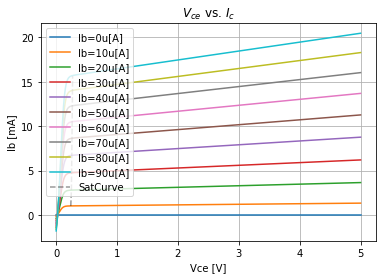

In [68]:
plt.title('$V_{ce}$ vs. $I_c$')

xs=OutputData.columns[0::2]
ys=OutputData.columns[1::2]
SatCurveVals=SatCurve(OutputData[xs[0]])
SatCurveM=SatCurveVals.max(); SatCurveM
SatCurveU=np.where(SatCurveVals==SatCurveM.max())[0][0]
SatCurveM, SatCurveU
SatCurveB=np.where(SatCurveVals>=0)[0]
SatCurveB=SatCurveB[np.where(SatCurveB<=SatCurveU)[0]]
SatCurveB

for x, y in zip(xs, ys):
    plt.plot(OutputData[x], OutputData[y]*1000, label=f'Ib={y[6:]}[A]')

    
plt.plot(OutputData[xs[0]][SatCurveB], SatCurve(OutputData[xs[0]][SatCurveB])*1000, 'k--', alpha=0.4, label='SatCurve')

plt.legend(loc='best')
plt.grid()
plt.xlabel('Vce [V]'); plt.ylabel('Ib [mA]');


## ouput load line

In [69]:
m, b, L2Line=LoadLine(5, Rc)
m, b

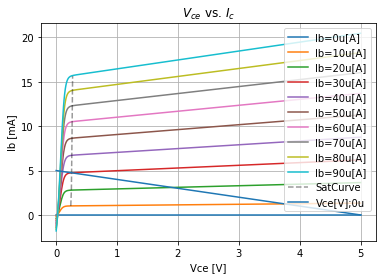

In [70]:
plt.title('$V_{ce}$ vs. $I_c$')

xs=OutputData.columns[0::2]
ys=OutputData.columns[1::2]
SatCurveVals=SatCurve(OutputData[xs[0]])
SatCurveM=SatCurveVals.max(); SatCurveM
SatCurveU=np.where(SatCurveVals==SatCurveM.max())[0][0]
SatCurveM, SatCurveU
SatCurveB=np.where(SatCurveVals>=0)[0]
SatCurveB=SatCurveB[np.where(SatCurveB<=SatCurveU)[0]]
SatCurveB

for x, y in zip(xs, ys):
    plt.plot(OutputData[x], OutputData[y]*1000, label=f'Ib={y[6:]}[A]')

    
plt.plot(OutputData[xs[0]][SatCurveB], SatCurve(OutputData[xs[0]][SatCurveB])*1000, 'k--', alpha=0.4, label='SatCurve')
plt.plot(OutputData[xs[0]], L2Line(OutputData[xs[0]])*1000)

plt.legend(loc='best')
plt.grid()
plt.xlabel('Vce [V]'); plt.ylabel('Ib [mA]');


In [71]:
xs=OutputData.columns[0::2]
ys=OutputData.columns[1::2]

OutputFits=OrderedDict()
for x, y in zip(xs, ys):
    OutputFits[y]=SciInterPol.interp1d(OutputData[x], OutputData[y], 
                                      bounds_error=False, fill_value='extrapolate')

In [72]:
LoadLineInterSectionsX2=[]
LoadLineInterSectionsY2=[]
x=np.linspace(0.0, OutputData[xs[0]].max(), OutputData[xs[0]].count())
K=list(OutputFits.keys()); K
for i in K:
    X=findIntersection(OutputFits[i] ,L2Line , 0.6)
    print(X)
    LoadLineInterSectionsX2.append(X[0])
    LoadLineInterSectionsY2.append(OutputFits[i](LoadLineInterSectionsX2[-1]))

LoadLineInterSectionsX2=np.array(LoadLineInterSectionsX2)
LoadLineInterSectionsY2=np.array(LoadLineInterSectionsY2)
LoadLineInterSectionsX2, LoadLineInterSectionsY2

[ 4.99999998]
[ 3.74961133]
[ 1.90417803]
[ 0.25040481]
[ 0.10650807]
[ 0.08821715]
[ 0.0784775]
[ 0.07207251]
[ 0.06738974]
[ 0.06379687]


/home/iridium/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


(array([ 4.99999998,  3.74961133,  1.90417803,  0.25040481,  0.10650807,
         0.08821715,  0.0784775 ,  0.07207251,  0.06738974,  0.06379687]),
 array([  2.03765893e-11,   1.25038867e-03,   3.09582197e-03,
          4.74959519e-03,   4.89349193e-03,   4.91178285e-03,
          4.92152250e-03,   4.92792749e-03,   4.93261026e-03,
          4.93620313e-03]))

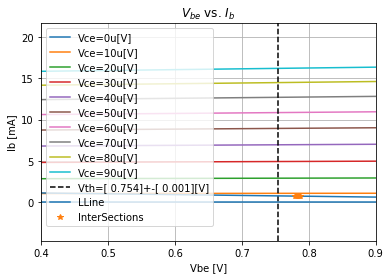

In [83]:
#! Need to move the lagend to the right of the graph
plt.title('$V_{be}$ vs. $I_b$')

xs=OutputData.columns[0::2]
ys=OutputData.columns[1::2]
for x, y in zip(xs, ys):
    plt.plot(OutputData[x], OutputData[y]*1000, label=f'Vce={y[6:]}[V]')
plt.axvline(x=ThershholdVoltageMean, linestyle='--', color='k', 
            label=f'Vth={ThershholdVoltageMean}+-{ThershholdVoltageStdDev}[V]')

xN=np.linspace(0.0, OutputData[xs[0]].max(), OutputData[xs[0]].count())
plt.plot(xN, L1Line(xN)*1000, label='LLine')
plt.plot(LoadLineInterSectionsX, LoadLineInterSectionsY*1000, '*', 
         label='InterSections')
plt.legend(loc='best')
plt.grid()
plt.xlabel('Vbe [V]'); plt.ylabel('Ib [mA]');
plt.xlim(0.4, 0.9);

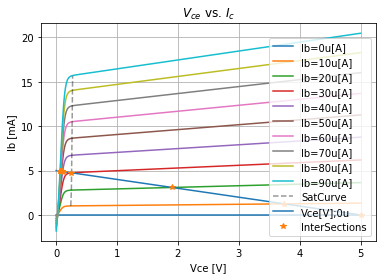

In [84]:
plt.title('$V_{ce}$ vs. $I_c$')

xs=OutputData.columns[0::2]
ys=OutputData.columns[1::2]
SatCurveVals=SatCurve(OutputData[xs[0]])
SatCurveM=SatCurveVals.max(); SatCurveM
SatCurveU=np.where(SatCurveVals==SatCurveM.max())[0][0]
SatCurveM, SatCurveU
SatCurveB=np.where(SatCurveVals>=0)[0]
SatCurveB=SatCurveB[np.where(SatCurveB<=SatCurveU)[0]]
SatCurveB

for x, y in zip(xs, ys):
    plt.plot(OutputData[x], OutputData[y]*1000, label=f'Ib={y[6:]}[A]')

    
plt.plot(OutputData[xs[0]][SatCurveB], SatCurve(OutputData[xs[0]][SatCurveB])*1000, 'k--', alpha=0.4, label='SatCurve')
plt.plot(OutputData[xs[0]], L2Line(OutputData[xs[0]])*1000)

xN=np.linspace(0.0, OutputData[xs[0]].max(), OutputData[xs[0]].count())

plt.plot(LoadLineInterSectionsX2, LoadLineInterSectionsY2*1000, '*', 
         label='InterSections')


plt.legend(loc='best')
plt.grid()
plt.xlabel('Vce [V]'); plt.ylabel('Ib [mA]');


In [85]:
VTCFit=SciInterPol.interp1d(LoadLineInterSectionsX2, LoadLineInterSectionsY2, 
                           bounds_error=False, fill_value='extrapolate')


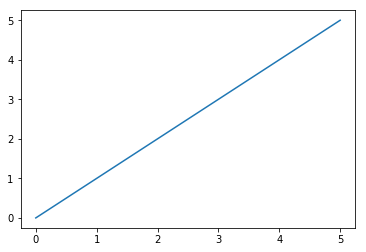

In [86]:
plt.plot(OutputData[xs[0]], 5-1e3*VTCFit(OutputData[xs[0]]))

In [87]:
Rc

UnitValue(1 kΩ)

# Current Transfer Curve (Need to work on)

In [88]:
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.dc(Ibase=slice(0, 100e-6, 10e-6))

2018-01-24 23:52:43,205 - PySpice.Spice.Simulation.NgSpiceSharedCircuitSimulator._run - DEBUG - desk
.title Transistor
.include /home/iridium/string12oil@gmail.com/MyProjects/EEM-Circuits/SpiceLib/2N2222A.lib
Ibase 0 base 90.0uA
Vcollector collector 0 5
Q1 collector base 0 2n2222a 
.options TEMP = 25°C
.options TNOM = 25°C
.ic 
.dc Ibase 0 0.0001 1e-05
.end

2018-01-24 23:52:43,206 - PySpice.Spice.NgSpice.Shared.NgSpiceShared.exec_command - DEBUG - Execute command: destroy all
2018-01-24 23:52:43,209 - PySpice.Spice.NgSpice.Shared.NgSpiceShared.run - DEBUG - Simulation is done
2018-01-24 23:52:43,210 - PySpice.Spice.Simulation.NgSpiceSharedCircuitSimulator._run - DEBUG - ['dc1', 'const']


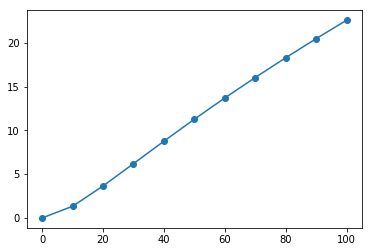

In [89]:
plt.plot(analysis.sweep*1e6, -analysis.Vcollector*1000, 'o-')
